# Feature Engineering

<!--BOOK_INFORMATION-->
*This notebook contains excerpts from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas (available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook)) with additional modifications and expansions by Julio Arriaga for TI3002C. For a more in depth explanation of SciKit-Learn refer to [the book](https://learning.oreilly.com/library/view/python-data-science/9781491912126/) and the official [Scikit-Learn user guide](https://scikit-learn.org/stable/user_guide.html)*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

The previous tutorial outlined the fundamental ideas of machine learning, but all of the examples assume that you have numerical data in a tidy, ``(n_samples, n_features)`` format.
In the real world, data rarely comes in such a form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Feature Extraction

As an example of a feature extraction process, let's take a look at reducing the dimensionality of the Iris data so as to more easily visualize it.
Recall that the Iris data is four dimensional: there are four features recorded for each sample.

The task of dimensionality reduction is to ask whether there is a suitable lower-dimensional representation that retains the essential features of the data.
Often dimensionality reduction is used as an aid to visualizing data: after all, it is much easier to plot data in two dimensions than in four dimensions or higher!

Here we will use principal component analysis (PCA), which is a fast linear dimensionality reduction technique.
We will ask the model to return two components—that is, a two-dimensional representation of the data.

Following the sequence of steps outlined earlier, we have:

In [2]:
import seaborn as sns
sns.set()
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [4]:
y_iris = iris['species']
y_iris.shape

(150,)

In [5]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_iris)                      # 3. Fit to data. Notice y is not specified, as it's not needed
X_2D = model.transform(X_iris)         # 4. Transform the data to two dimensions

Now let's plot the results. A quick way to do this is to insert the results into the original Iris ``DataFrame``, and use Seaborn's ``lmplot`` to show the results:

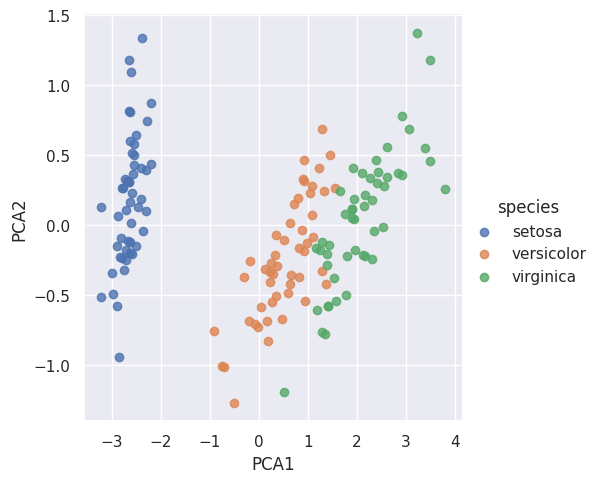

In [6]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot(x="PCA1", y="PCA2", hue='species', data=iris, fit_reg=False);

We see that in the two-dimensional representation, the species are fairly well separated, even though the PCA algorithm had no knowledge of the species labels!
This indicates to us that a relatively straightforward classification will probably be effective on the dataset, as we saw before.

## Feature Selection

[`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) is a simple baseline approach to feature selection. It removes all features whose variance doesn't meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In [7]:
from sklearn.feature_selection import VarianceThreshold

# Create a sample dataset with low-variance and high-variance features
data = np.array([
    [1, 2, 3],
    [1, 5, 2],
    [1, 8, 2],
    [1, 8, 1],
    [2, 1, 3],
    [1, 3, 2]
])

threshold = 0.2  # Features with variance less than this will be removed
selector = VarianceThreshold(threshold=threshold)

# Fit the selector to the data and transform the data
data_high_variance = selector.fit_transform(data)

# Get the indices of selected features
selected_indices = selector.get_support(indices=True)

# Print the original data, selected indices, and the data with low-variance features removed
print("Original Data:")
print(data)

print("\nSelected Indices (High Variance Features):")
print(selected_indices)

print("\nData after Removing Low-Variance Features:")
print(data_high_variance)


Original Data:
[[1 2 3]
 [1 5 2]
 [1 8 2]
 [1 8 1]
 [2 1 3]
 [1 3 2]]

Selected Indices (High Variance Features):
[1 2]

Data after Removing Low-Variance Features:
[[2 3]
 [5 2]
 [8 2]
 [8 1]
 [1 3]
 [3 2]]


Another approach is to automatically select the best scoring *k* features based on some test using [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html). For instance, we can use a F-test to retrieve the two best features for a dataset as follows:

In [8]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X, y = load_iris(return_X_y=True)
print("Original dataset shape:", X.shape)

X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
print("Dataset after keeping 2 best scoring features:", X_new.shape)

Original dataset shape: (150, 4)
Dataset after keeping 2 best scoring features: (150, 2)


`SelectKBest` takes as input a scoring function that returns univariate scores. Available functions are:

- For regression: `r_regression`, `f_regression`, `mutual_info_regression`
- For classification: `chi2`, `f_classif`, `mutual_info_classif`

You can read more about feature selection in Scikit in the [documentation](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

## Feature Creation

Feature creation can involve generating new features from the existing ones to capture additional information or relationships between the variables. Here's an example of creating a new feature based on the Iris dataset:

In [ ]:
X_iris.head()

In [9]:
# Example of Feature Creation: Petal Area
X_iris['petal_area'] = X_iris['petal_length'] * X_iris['petal_width']

X_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,petal_area
0,5.1,3.5,1.4,0.2,0.28
1,4.9,3.0,1.4,0.2,0.28
2,4.7,3.2,1.3,0.2,0.26
3,4.6,3.1,1.5,0.2,0.30
4,5.0,3.6,1.4,0.2,0.28


Another simple and common method to use is polynomial features, which can get features' high-order and interaction terms. It is implemented in [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html):



In [10]:
from sklearn.preprocessing import PolynomialFeatures
X = np.arange(6).reshape(3, 2)
print("Original Data")
print(X)
poly = PolynomialFeatures(2)
print("Transformed Data")
X = poly.fit_transform(X)
print(X)

Original Data
[[0 1]
 [2 3]
 [4 5]]
Transformed Data
[[ 1.  0.  1.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


We can see, the features of $X$ have been transformed from $(X_{1},X_{2})$ to $(1,X_{1},X_{2},X^{2}_{1},X_{1}X_{2},X^{2}_{2})$.

You can read more about feature creation in the [documentation](https://scikit-learn.org/stable/modules/preprocessing.html#polynomial-features)

## Feature Transformation

### Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [11]:
import pandas as pd
data = pd.DataFrame([
    [850000, 4, 'Queen Anne'],
    [700000, 3, 'Fremont'],
    [650000, 3, 'Wallingford'],
    [600000, 2, 'Fremont']
], columns=['price', 'rooms', 'neighborhood'])
print(data)

    price  rooms neighborhood
0  850000      4   Queen Anne
1  700000      3      Fremont
2  650000      3  Wallingford
3  600000      2      Fremont


You might be tempted to encode this data with a straightforward numerical mapping:

In [ ]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

This is not generally a useful approach in Machine Learning as most models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as an array, Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) will do this for you:

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
data[ohe.categories_[0]] = ohe.fit_transform(data[['neighborhood']])
data = data.drop('neighborhood', axis=1) # remove the now encoded column
print(data)

    price  rooms  Fremont  Queen Anne  Wallingford
0  850000      4      0.0         1.0          0.0
1  700000      3      1.0         0.0          0.0
2  650000      3      0.0         0.0          1.0
3  600000      2      1.0         0.0          0.0


Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

Also notice the encoder saves the original labels in the `categories_` attribute.

In [13]:
ohe.categories_

[array(['Fremont', 'Queen Anne', 'Wallingford'], dtype=object)]

One might want to drop one of the two columns for features with 2 categories. In this case, you can set the parameter `drop='if_binary'`

OneHotEncoder also supports categorical features with missing values by considering the missing values as an additional category.

### Column Transformers

Scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) is a versatile tool that allows you to apply different preprocessing steps to different subsets of your feature columns. This is particularly useful when you have a mix of numerical and categorical features that require different transformations. It is particularly useful for one-hot encoding categorical features while scaling numerical features, puls it enhances workflow efficiency by combining transformations in a single step.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Generate example data
data = {
    'Age': [25, 32, 45, 29, 22, 20, 19, 54],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Female', 'Male'],
    'Salary': [50000, 60000, 75000, 55000, 48000, 25000, 33000, 40000],
    'Label': [1, 1, 1, 0, 1, 0, 0, 0]
}

df = pd.DataFrame(data)

# Separate features and labels
X = df.drop('Label', axis=1)
y = df['Label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Define preprocessing steps using ColumnTransformer
numeric_features = ['Age', 'Salary']
numeric_transformer = StandardScaler()

categorical_features = ['Gender']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.50


### Imputation of Missing Data

Another common need in feature engineering is handling of missing data.
Often the ``NaN`` value is used to mark missing values.
For example, we might have a dataset that looks like this:

In [15]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

When applying a typical machine learning model to such data, we will need to first replace such missing data with some appropriate fill value.
This is known as *imputation* of missing values.
For a baseline imputation approach, using the mean, median, or most frequent value, Scikit-Learn provides the [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) class:

In [16]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

There are several other imputers available, you can check more of them in the [official sklearn documentation](https://scikit-learn.org/stable/modules/impute.html). For instance, the ``KNNImputer`` class for imputing missing values using the k-nearest neighbors approach. This method replaces missing values in a dataset with values from the nearest neighbors, which helps retain the underlying data distribution. This is especially useful for datasets with complex inter-feature relationships, as it maintains consistency in imputed values compared to simple mean imputation.

In [17]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values=np.nan, n_neighbors=2)
X2 = imp.fit_transform(X)
X2

array([[3.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 6. , 6. ],
       [8. , 8. , 1. ]])

### Feature Scaling and Normalization

Scikit-learn provides tools for normalization and feature scaling, which are essential preprocessing steps in machine learning. These techniques help ensure that different features are on similar scales, preventing certain features from dominating the learning process.

Normalization and Feature Scaling are essential preprocessing steps:
- Normalization scales features to a specific range (e.g., [0, 1]).
- Standardization (z-score scaling) transforms features to have a mean of 0 and standard deviation of 1.

Use Cases:
- Many machine learning algorithms perform better when features are on similar scales.
- Useful when features have different units or ranges.
- Gradient descent-based algorithms converge faster with scaled features.

In [18]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create pipelines with different scaling methods
pipelines = {
    'No Scaling': Pipeline([('classifier', LogisticRegression())]),
    'StandardScaler': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())]),
    'MinMaxScaler': Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])
}

# Train and evaluate pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} - Accuracy: {accuracy:.2f}')

No Scaling - Accuracy: 1.00
StandardScaler - Accuracy: 1.00
MinMaxScaler - Accuracy: 0.91


You can learn more about Scikit-Learn's feature scaling funcionality in the [official documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#importance-of-feature-scaling).

#### A note on feature scaling and imputation

The recommended order between imputing missing values and scaling features depends on the specific characteristics of your data and the goals of your analysis. Both approaches have their merits, and the choice may vary based on the nature of the missing data and the algorithms you intend to use.

**1. Impute and Then Scale:**
This approach involves imputing missing values before applying feature scaling. The rationale behind this approach is that imputing missing values prior to scaling ensures that the imputed values are on the same scale as the other data points, preventing inconsistencies in scaling.

**Advantages:**
- Imputing before scaling maintains the integrity of the imputed values relative to the rest of the dataset.
- It can be particularly useful when imputation is performed based on relationships between features.

**Considerations:**
- If the imputation method depends on feature scales, applying scaling before imputation might be more appropriate.

**2. Scale and Then Impute:**
Scaling the features before imputing missing values means that the imputed values will be affected by the scaling process. This approach might be suitable when the imputation method is not sensitive to feature scales.

**Advantages:**
- Scaling before imputation ensures that the imputed values adhere to the same scaling strategy as the rest of the dataset.

**Considerations:**
- Scaling before imputation could potentially introduce distortions in the imputed values if the imputation method relies on relationships between features.

**General Recommendations:**
- If your imputation method is independent of feature scales (e.g., using nearest neighbors), it might be better to scale first and then impute.
- If your imputation method relies on relationships between features and feature scales (e.g., using regression-based imputation), impute first and then scale.

Ultimately, the choice between imputing and scaling depends on the specific dataset, the nature of the missing data, and the goals of your analysis. It's a good practice to experiment with both approaches and evaluate their impact on the performance of your machine learning models to determine which approach works best for your particular use case.

### Practice SciKit-Learn

Load the `penguins` dataset (available directly through seaborn) and create a classification model that predicts the species of a penguin using SciKit.


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

# Load the penguin dataset into a Dataframe
peng = sns.load_dataset('penguins')

peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [21]:
peng.isna().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


In [22]:
# Split dataframes into X and y (if necessary)
X_peng = peng.drop(['species'], axis=1)
y_peng = peng['species']

# Split into training and testing sets
X_peng_train, X_peng_test, y_peng_train, y_peng_test = train_test_split(X_peng, y_peng)

# Build a pipeline with steps to:
# Hot-encode categorical attributes (if necessary)
# Impute missing values (if necessary)
# Scale/Normalize features (if necessary)
# Choose a classification model

# Define preprocessing steps using ColumnTransformer and Pipeline
numeric_features = ['bill_length_mm', 'bill_depth_mm',	'flipper_length_mm', 'body_mass_g']
numeric_transformer = StandardScaler()

categorical_features = ['island', 'sex']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),
                           ('classifier', LogisticRegression())])

# Fit the pipeline on the training data
pipeline.fit(X_peng_train, y_peng_train)

# Predict using the pipeline
y_peng_pred = pipeline.predict(X_peng_test)

# Calculate accuracy
accuracy = accuracy_score(y_peng_test, y_peng_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99
